# Ionosonde Plotting Script
Nathaniel A. Frissell W2NAF and Stephen A. Cerwin WA5FRF

October 31, 2023

This script will automatically pull ionosonde data from the DigiSonde FastChar API and plot it.

## Useful Links and Documentation
* **DigiSonde Manual**: https://digisonde.com/pdf/Digisonde4DManual_LDI-web.pdf
* **IonoWeb Portal**: https://digisonde.com/pdf/Digisonde4DManual_LDI-web.pdf
* **FastChar**: https://giro.uml.edu/didbase/scaled.php

## Load in Libraries and Define Functions

In [1]:
import os
import datetime

from urllib.request import urlretrieve

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import pandas as pd

%matplotlib inline

In [2]:
# Sets default style and font parameters for the plots we are making.
mpl.rcParams['font.size']      = 16
# mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = (12,9)
mpl.rcParams['axes.xmargin']   = 0
mpl.rcParams['axes.ymargin']   = 0.1

# Specify Desired Paramaters

In [3]:
# Enter desired parameters
# ursiCode = 'BC840' # Boulder
ursiCode = 'AU930' # Austin

sTime = datetime.datetime(2023,10,31,5)
eTime = datetime.datetime(2023,10,31,15)

params = []
params.append('foF2')
params.append('hmF2')
params.append('foEs')

In [4]:
# Specify where you want the data stored.
data_dir = 'digisonde_data'

# Create a Parameter Dictionary

In [5]:
prmd = {}

pdct = prmd['foF2'] = {}
pdct['label'] = 'foF2 [MHz]'

pdct = prmd['hmF2'] = {}
pdct['label'] = 'hmF2 [km]'

pdct = prmd['foEs'] = {}
pdct['label'] = 'foEs [MHz]'

In [6]:
usriDct = {}

udct = usriDct['AU930'] = {}
udct['title'] = 'Austin, TX (AU930)'

udct = usriDct['BC840'] = {}
udct['title'] = 'Boulder, CO (BC840)'

# Download and Process Data

## Download Data

In [7]:
# Create Data Directory
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [8]:
# Format parameters into URL
# Example URL: https://lgdc.uml.edu/fastchar/getbest?ursiCode=MHJ45&charName=foF2,hmF2,foEs
base_url  = 'https://lgdc.uml.edu/fastchar/getbest?'

url_params  = []
url_params.append('ursiCode='+ursiCode)
url_params.append('fromDate='+sTime.strftime('%Y.%m.%dT%H:%M'))
url_params.append('toDate='+eTime.strftime('%Y.%m.%dT%H:%M'))
url_params.append('charName='+','.join(params))

url_get = '&'.join(url_params)

url = base_url+url_get

print(url)

https://lgdc.uml.edu/fastchar/getbest?ursiCode=AU930&fromDate=2023.10.31T05:00&toDate=2023.10.31T15:00&charName=foF2,hmF2,foEs


In [9]:
# Format filename
fName = []
fName.append(ursiCode)
fName.append(sTime.strftime('%Y%m%d.%H%M')+'-'+eTime.strftime('%Y%m%d.%H%M'))
fName.append('_'.join(params))
fName = '_'.join(fName)+'.txt'

fPath = os.path.join(data_dir,fName)

In [10]:
# Download the data file.
result = urlretrieve(url, fPath)

## Create Data Frame From Data

In [11]:
# Create Column Headers
cols = []
cols.append('Time')
cols.append('CS') # CS [percent] = Autoscaling Confidence Score (from 0 to 100, 999 if manual scaling, -1 if unknown)

for param in params:
    cols.append(param)
    cols.append(param+'_QD')

In [12]:
# Load file into dataframe
df = pd.read_table(fPath,comment='#',delim_whitespace=True,names=cols,parse_dates=[0])

# Remove timezone info (All are in UTC)
df['Time'] = [x.replace(tzinfo=None) for x in df['Time']]

# Force all parameter columns into a numeric format. Set all non-numeric
# values to NaN.
for param in params:
    df[param] = pd.to_numeric(df[param],errors='coerce')

In [13]:
df

,Time,CS,foF2,foF2_QD,hmF2,hmF2_QD,foEs,foEs_QD
0,2023-10-31 05:00:05,100,5.10,//,333.6,//,NaN,__
1,2023-10-31 05:05:05,100,5.10,//,321.2,//,NaN,__
2,2023-10-31 05:10:05,100,5.40,//,355.9,//,NaN,__
3,2023-10-31 05:15:05,100,5.20,//,328.8,//,NaN,__
4,2023-10-31 05:20:05,100,5.50,//,354.6,//,4.2,//
...,...,...,...,...,...,...,...,...
115,2023-10-31 14:35:05,70,10.80,//,231.9,//,2.7,//
116,2023-10-31 14:40:05,100,11.05,//,241.5,//,5.7,//
117,2023-10-31 14:45:05,100,10.65,//,230.9,//,2.9,//
118,2023-10-31 14:50:05,100,10.40,//,230.9,//,3.0,//


In [14]:
df.describe()

,CS,foF2,hmF2,foEs
count,120.000000,120.000000,120.000000,32.000000
mean,97.333333,5.963642,308.381667,3.271875
std,13.825645,1.913131,39.782417,1.290470
min,0.000000,4.100000,230.900000,1.200000
25%,100.000000,4.900000,278.600000,2.375000
50%,100.000000,5.300000,309.800000,2.800000
75%,100.000000,5.612500,333.950000,4.125000
max,100.000000,11.250000,473.700000,6.400000


# Plot the Data

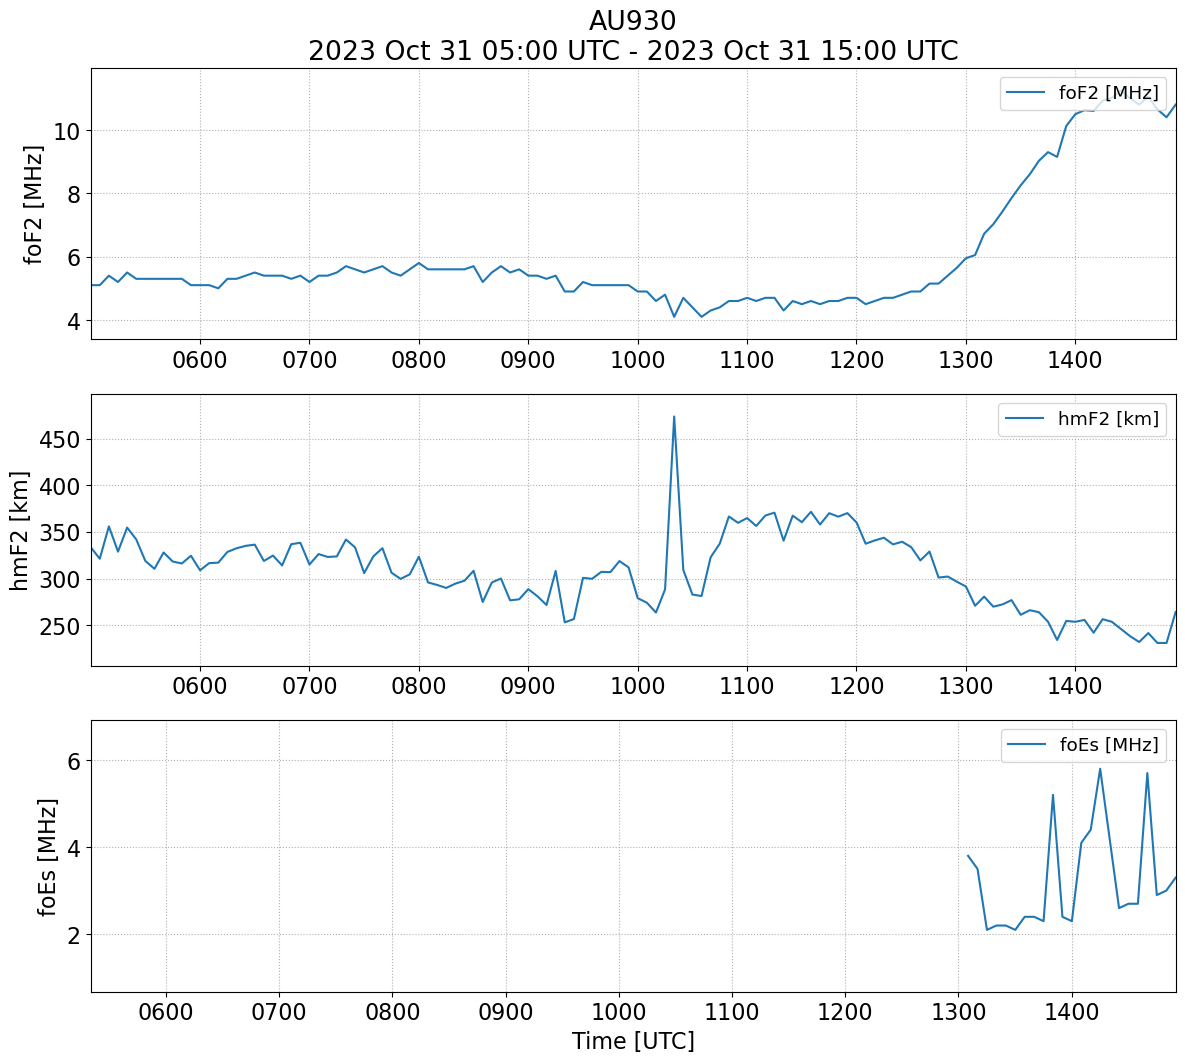

In [15]:
nRows = len(params)
fig = plt.figure(figsize=(14,4*nRows))

for inx,param in enumerate(params):
    pdct = prmd.get(param,{})
    udct = prmd.get(ursiCode,{})
    
    ax  = fig.add_subplot(nRows,1,inx+1)
    
    xx  = df['Time']
    yy  = df[param]
    
    if inx == 0:
        tfmt = '%Y %b %d %H:%M UTC'
        title = []
        title.append(udct.get('title',ursiCode))
        title.append('{!s} - {!s}'.format(sTime.strftime(tfmt),eTime.strftime(tfmt)))
        ax.set_title('\n'.join(title))
    
    if inx == nRows-1:
        ax.set_xlabel('Time [UTC]')
    
    label = pdct.get('label',param)
    ax.set_ylabel(label)
    
    ax.plot(xx,yy,label=label)

    ax.legend(loc='upper right',fontsize='small')
    
    xticks = ax.get_xticks()
    xtls = []
    for xtick in xticks:
        xtd = mpl.dates.num2date(xtick)
        xtl = xtd.strftime('%H%M')
        xtls.append(xtl)
        
    ax.xaxis.set_ticks(xticks)
    ax.set_xticklabels(xtls)
    
plt.show()